# Visibilities with 3 holes
With three holes we have 3 baselines and the images become harder to interpret, and fitting three sets of fringes impractical. Fourier transforming the image to get the visibilities is therefore the best option.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib notebook

## First estimate what the image will look like
We do this by setting up the FT with six points to represent the three baselines, and one in the center for the PSF.

In [2]:
# set the image size to use below
nxy = 512

In [3]:
def gauss(sigma, peak=1, xoff=0, yoff=0):
    xc = nxy/2 + xoff
    yc = nxy/2 + yoff
    x = np.arange(nxy) - xc
    y = np.arange(nxy) - yc
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt( xx**2 + yy**2 )
    return peak * np.exp(-0.5 * (r/sigma)**2)

<IPython.core.display.Javascript object>


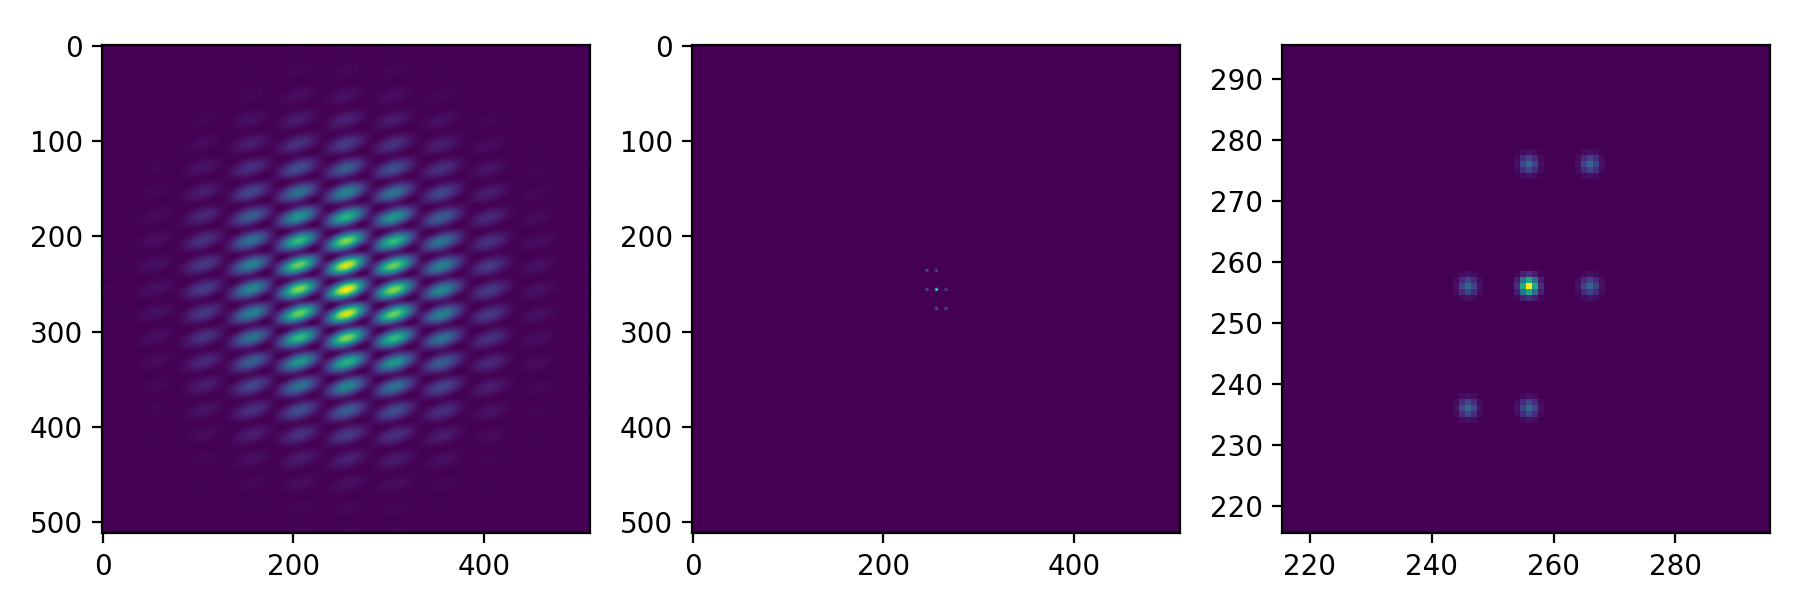

In [4]:
# simulate what the image and FT will look like for a three-hole source
vis = 1
width = 1

vpk = vis / 3
ft =  gauss(width, peak=1)              # PSF
ft += gauss(width, xoff=10, peak=vpk)   # fringe
ft += gauss(width, xoff=-10, peak=vpk)  # fringe
ft += gauss(width, xoff=0, yoff=20, peak=vpk)   # fringe
ft += gauss(width, xoff=0, yoff=-20, peak=vpk)  # fringe
ft += gauss(width, xoff=10, yoff=20, peak=vpk)   # fringe
ft += gauss(width, xoff=-10, yoff=-20, peak=vpk)  # fringe

im = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(ft)))
im = np.real(im)
im /= np.max(np.abs(im))

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(np.abs(im))
ax[1].imshow(np.abs(ft))
ax[2].imshow(np.abs(ft))

# zoom the second FT
cx = (ft.shape[1]-1) / 2
cy = (ft.shape[0]-1) / 2
n = 20 #np.max([np.abs(mxy[0]-cy), np.abs(mxy[1]-cx)])
ax[2].set_xlim(cx-2*n,cx+2*n)
ax[2].set_ylim(cy-2*n,cy+2*n)

fig.tight_layout()

# Real data
An example of reading a FITS file and plotting the Fourier transform

In [5]:
im = fits.getdata('../testdata/3h/2023-01-12-1207_7-U-B-Jup_0000_r.fits')
im = fits.getdata('../testdata/3h/2023-01-12-1208_5-U-B-Jup_0000_g.fits')
# im = fits.getdata('../testdata/3h/2023-01-12-1209_1-U-B-Jup_0000_b.fits')
im = im - np.percentile(im.astype(float), 40)

<IPython.core.display.Javascript object>


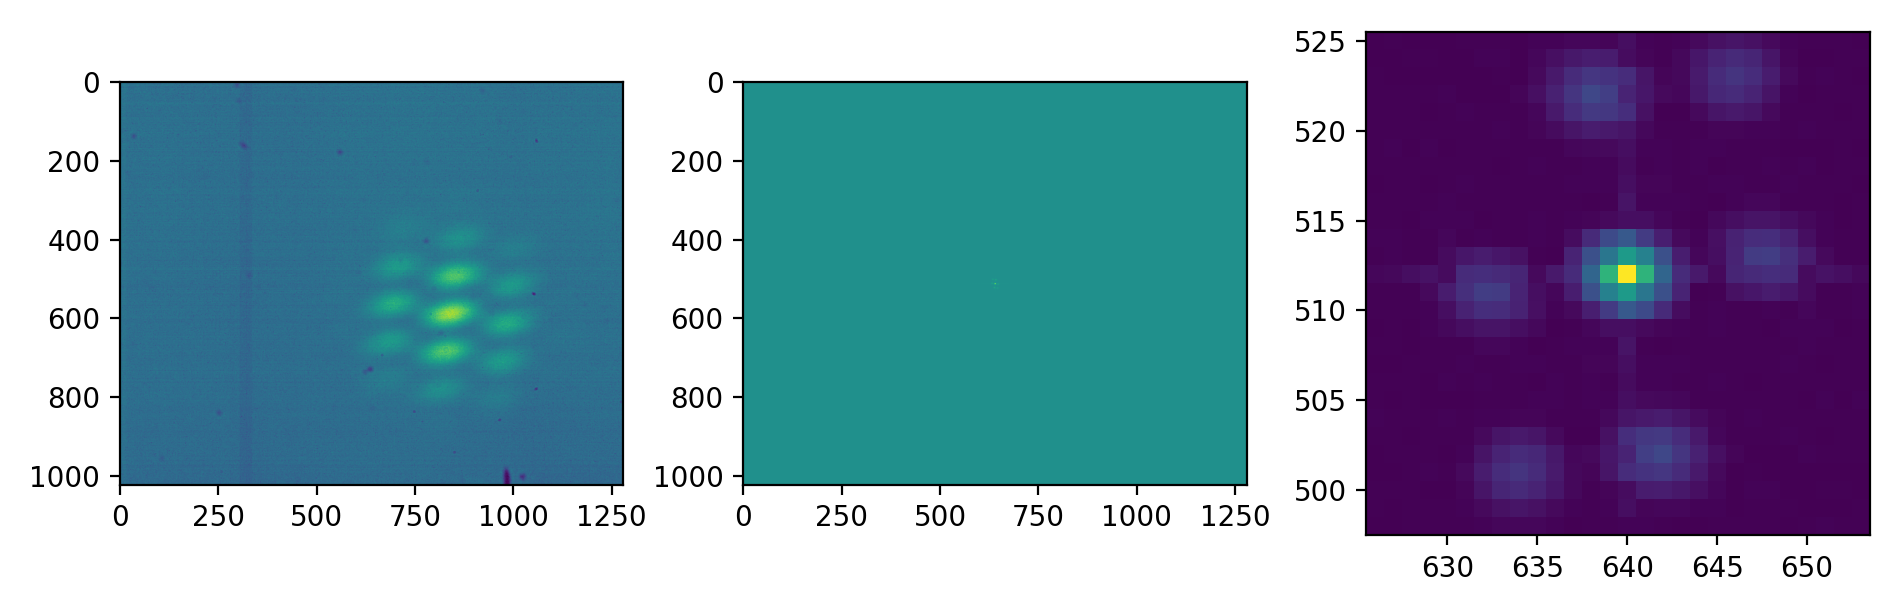

In [6]:
ft = np.fft.fftshift(np.fft.fft2(im))
ft = np.abs(ft)
ft /= np.max(ft)

fig, ax = plt.subplots(1, 3, figsize=(9.5,3))
ax[0].imshow(im)
ax[1].imshow(ft, vmin=-1, vmax=1)
ax[2].imshow(ft, vmax=1)

# zoom the second FT
cx = (ft.shape[1]-1) / 2
cy = (ft.shape[0]-1) / 2
n = 7 #np.max([np.abs(mxy[0]-cy), np.abs(mxy[1]-cx)])
ax[2].set_xlim(cx-2*n,cx+2*n)
ax[2].set_ylim(cy-2*n,cy+2*n)

fig.tight_layout()

In [7]:
np.unravel_index(np.argmax(ft), ft.shape)

(512, 640)

Here we have the image at left, the FT in the middle, and a zoomed version of the FT at the right. The FT has three pairs of peaks, plus the PSF peak in the center. Each pair of peaks corresponds to a baseline, and we can figure out which is which by knowing that the shortest baseline corresponds to the lowest frequency, which is closer to the center of the FT.

To get visiblities, we take one value for each pair of peaks (the values will be identical), and mulitply by three (as we have 3 holes). We then assign each of these to a baseline and wavelength to get the $b/\lambda$ value, which we can then fit a visibility curve to as for two holes.

In [8]:
v_r = [0.133, 0.151, 0.128]
v_g = [0.107, 0.124, 0.088]
v_b = [0.096, 0.105, 0.076]